## Chris, TensorFlow Transformer - [0.790]

* https://www.kaggle.com/code/cdeotte/tensorflow-transformer-0-790

In [50]:
import cupy # cudf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gc, os

PATH_TO_DATA = "/mnt/sdb/KAGGLE_DATA/amex-default-prediction/amex-data-for-transformers-and-rnns/data/"
TRAIN_MODEL = True
PATH_TO_MODEL = "./output/chris_transformer_tmp/"

INFER_TEST = True

### Build Transformer Model --

In [51]:
os.environ["TF_GPU_ALLOCATOR"] = "cuda_malloc_async"  # TF will not use all memory --
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow import keras
from tensorflow.keras import layers

print("Using TensorFlow version", tf.__version__)

Using TensorFlow version 2.10.0


In [52]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, feat_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [
                layers.Dense(ff_dim, activation="gelu"),
                layers.Dense(feat_dim)
            ]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [53]:
feat_dim = 188
embed_dim = 64 # embedding size for attention --
num_heads = 4 # number of attention heads --
ff_dim = 128 # hidden layer size in feed forward network inside transformer --
dropout_rate = 0.3
num_blocks = 2

In [54]:
def build_model():

    # input embedding layer --
    inp = layers.Input(shape=(13, 188))
    embeddings = []
    for k in range(11):
        emb = layers.Embedding(10, 4)
        embeddings.append(emb(inp[:, :, k]))
    x = layers.Concatenate()([inp[:, :, 11:]]+embeddings)
    x = layers.Dense(feat_dim)(x)

    # transformer blocks --
    for k in range(num_blocks):
        x_old = x
        transformer_block = TransformerBlock(embed_dim, feat_dim, num_heads, ff_dim, dropout_rate)
        x = transformer_block(x)
        x = 0.9*x + 0.1*x_old  # skip connection --
    
    # classification head --
    x = layers.Dense(64, activation="relu")(x[:,-1,:])
    x = layers.Dense(32, activation="relu")(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)

    model = keras.Model(inputs=inp, outputs=outputs)
    opt = tf.keras.optimizers.Adam(learning_rate=0.001)
    loss = tf.keras.losses.BinaryCrossentropy()
    model.compile(loss=loss, optimizer=opt)

    return model

### Define Learning Schedule

Learning rate schedule: 0.001 to 0.001 to 1e-06


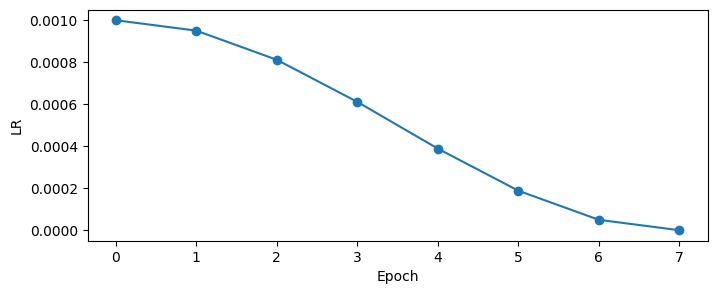

In [55]:
import math
LR_START = 1e-6
LR_MAX = 1e-3
LR_MIN = 1e-6
LR_RAMPUP_EPOCHS = 0
LR_SUSTAIN_EPOCHS = 0
EPOCHS = 8

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS*epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        decay_total_epochs = EPOCHS - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS - 1
        decay_epoch_index = epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS
        phase = math.pi*decay_epoch_index/decay_total_epochs
        cosine_decay = 0.5*(1 + math.cos(phase))
        lr = (LR_MAX - LR_MIN)*cosine_decay + LR_MIN
    return lr

rng = [i for i in range(EPOCHS)]
lr_y = [lrfn(x) for x in rng]
fig, ax = plt.subplots(figsize=(8, 3))
ax.plot(rng, lr_y, "-o")
ax.set_xlabel("Epoch"); ax.set_ylabel("LR")
print(f"Learning rate schedule: {lr_y[0]:.3g} to {max(lr_y):.3g} to {lr_y[-1]:.3g}")

In [56]:
LR = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=True)

### Define Competition Metric --

In [57]:
# COMPETITION METRIC FROM Konstantin Yakovlev
# https://www.kaggle.com/kyakovlev
# https://www.kaggle.com/competitions/amex-default-prediction/discussion/327534
def amex_metric_mod(y_true, y_pred):

    labels     = np.transpose(np.array([y_true, y_pred]))
    labels     = labels[labels[:, 1].argsort()[::-1]]
    weights    = np.where(labels[:,0]==0, 20, 1)
    cut_vals   = labels[np.cumsum(weights) <= int(0.04 * np.sum(weights))]
    top_four   = np.sum(cut_vals[:,0]) / np.sum(labels[:,0])

    gini = [0,0]
    for i in [1,0]:
        labels         = np.transpose(np.array([y_true, y_pred]))
        labels         = labels[labels[:, i].argsort()[::-1]]
        weight         = np.where(labels[:,0]==0, 20, 1)
        weight_random  = np.cumsum(weight / np.sum(weight))
        total_pos      = np.sum(labels[:, 0] *  weight)
        cum_pos_found  = np.cumsum(labels[:, 0] * weight)
        lorentz        = cum_pos_found / total_pos
        gini[i]        = np.sum((lorentz - weight_random) * weight)

    return 0.5 * (gini[1]/gini[0] + top_four)

### Train Model --

In [58]:
if TRAIN_MODEL:

    # save true and oof --
    true = np.array([])
    oof = np.array([])
    VERBOSE = 2  # use 1 for interactive --

    for fold in range(5):

        # indices of train and valid folds --
        valid_idx = [2*fold+1, 2*fold+2]
        train_idx = [x for x in [1,2,3,4,5,6,7,8,9,10] if x not in valid_idx]
        print("#"*25)
        print(f"### Fold {fold+1} with valid files", valid_idx)

        # read train data from disk --
        X_train = []; y_train = []
        for k in train_idx:
            X_train.append(np.load(f"{PATH_TO_DATA}data_{k}.npy"))
            y_train.append(pd.read_parquet(f"{PATH_TO_DATA}targets_{k}.pqt"))
        X_train = np.concatenate(X_train, axis=0)
        y_train = pd.concat(y_train).target.values
        print("### Training data shapes", X_train.shape, y_train.shape)

        # read valid data from disk --
        X_valid = []; y_valid = []
        for k in valid_idx:
            X_valid.append(np.load(f"{PATH_TO_DATA}data_{k}.npy"))
            y_valid.append(pd.read_parquet(f"{PATH_TO_DATA}targets_{k}.pqt"))
        X_valid = np.concatenate(X_valid, axis=0)
        y_valid = pd.concat(y_valid).target.values
        print("### Validation data shapes", X_valid.shape, y_valid.shape)
        print("#"*25)

        # build and train model --
        K.clear_session()
        model = build_model()
        h = model.fit(
            X_train, y_train,
            validation_data = (X_valid, y_valid),
            batch_size=512, epochs=EPOCHS, verbose=VERBOSE,
            callbacks=[LR]
        )

        if not os.path.exists(PATH_TO_MODEL): os.makedirs(PATH_TO_MODEL)
        model.save_weights(f"{PATH_TO_MODEL}transformer_fold_{fold+1}.h5")

        # infer valid data --
        p = model.predict(X_valid, batch_size=512, verbose=VERBOSE).flatten()

        print()
        print(f"Fold {fold+1} CV=", amex_metric_mod(y_valid, p))
        print()
        true = np.concatenate([true, y_valid])
        oof = np.concatenate([oof, p])

        # clean memory --
        del model, X_train, y_train, X_valid, y_valid, p; gc.collect()

    # print overall results --
    print("#"*25)
    print(f"Overall CV = ", amex_metric_mod(true, oof))


#########################
### Fold 1 with valid files [1, 2]
### Training data shapes (367131, 13, 188) (367131,)
### Validation data shapes (91782, 13, 188) (91782,)
#########################


2022-09-28 22:33:22.182676: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-28 22:33:22.183050: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-28 22:33:22.183129: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-28 22:33:22.183409: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/8


2022-09-28 22:33:45.941765: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 897260832 exceeds 10% of free system memory.
2022-09-28 22:33:46.351023: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 897260832 exceeds 10% of free system memory.


718/718 - 23s - loss: 0.2406 - val_loss: 0.2477 - lr: 0.0010 - 23s/epoch - 33ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.0009505339495172585.
Epoch 2/8
718/718 - 19s - loss: 0.2307 - val_loss: 0.2356 - lr: 9.5053e-04 - 19s/epoch - 26ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.0008119331560284375.
Epoch 3/8
718/718 - 20s - loss: 0.2279 - val_loss: 0.2303 - lr: 8.1193e-04 - 20s/epoch - 28ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.0006116492065111791.
Epoch 4/8
718/718 - 20s - loss: 0.2231 - val_loss: 0.2333 - lr: 6.1165e-04 - 20s/epoch - 28ms/step

Epoch 5: LearningRateScheduler setting learning rate to 0.00038935079348882104.
Epoch 5/8
718/718 - 21s - loss: 0.2201 - val_loss: 0.2296 - lr: 3.8935e-04 - 21s/epoch - 29ms/step

Epoch 6: LearningRateScheduler setting learning rate to 0.00018906684397156263.
Epoch 6/8
718/718 - 20s - loss: 0.2164 - val_loss: 0.2262 - lr: 1.8907e-04 - 20s/epoch - 28ms/step

Epoch 7: Learning

2022-09-28 22:36:10.453716: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 897260832 exceeds 10% of free system memory.


180/180 - 3s - 3s/epoch - 15ms/step

Fold 1 CV= 0.7864107176161916

#########################
### Fold 2 with valid files [3, 4]
### Training data shapes (367131, 13, 188) (367131,)
### Validation data shapes (91782, 13, 188) (91782,)
#########################

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/8
718/718 - 25s - loss: 0.2412 - val_loss: 0.2380 - lr: 0.0010 - 25s/epoch - 35ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.0009505339495172585.
Epoch 2/8
718/718 - 22s - loss: 0.2305 - val_loss: 0.2333 - lr: 9.5053e-04 - 22s/epoch - 31ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.0008119331560284375.
Epoch 3/8
718/718 - 20s - loss: 0.2274 - val_loss: 0.2284 - lr: 8.1193e-04 - 20s/epoch - 28ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.0006116492065111791.
Epoch 4/8
718/718 - 21s - loss: 0.2240 - val_loss: 0.2285 - lr: 6.1165e-04 - 21s/epoch - 29ms/step

Epoch 5: LearningRateScheduler setting lea

### Infer Test data